<a href="https://colab.research.google.com/github/zergswim/Diffusion/blob/main/DiffusionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                          transform=torchvision.transforms.ToTensor())
mnist_train, mnist_val = random_split(mnist_train, [500, 59500])

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=32)

class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(

            # nn.Conv2d(1, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64, track_running_stats = False),
            # nn.ReLU(),
            # nn.Conv2d(64, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256, track_running_stats = False),
            # nn.ReLU(),

            # nn.MaxPool2d(2),

            # nn.Flatten(),
            # nn.Linear(in_features=50176, out_features=784),

            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        ).to(device)

        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        ).to(device)

        self.time_mlp = nn.Sequential(
            nn.Linear(1, 784),
            nn.ReLU()
        ).to(device)

    def forward(self, x, t):
        # x = x.view(x.size(0), 1, 28, 28)  # 입력 x를 reshape
        x = x.view(x.size(0), -1)  # 입력 x를 평탄화합니다.
        # x = self.pos_encoding(x, t) #pos 인코딩 생략
        z = self.encoder(x)

        # z = z.view(z.size(0), -1)  # 입력 x를 평탄화합니다.
        x_hat = self.decoder(z)
        return x_hat

    # def pos_encoding(self, x, t):
    #     t = torch.FloatTensor([t*0.1]*x.size(0))
    #     t = t.view(x.size(0), 1)
    #     t = self.time_mlp(t)
    #     x = torch.cat([x, t], dim=-1)
    #     return t

def train(model, noise_fn, epochs, steps=10):
  optimizer = torch.optim.Adam(model.parameters())

  from skimage.util import random_noise

  # 모델 사전 학습
  for epoch in range(epochs):
      # model.train()
      for batch in train_loader:
          images, _ = batch
          images = images.to(device)
          images_flat = images.view(images.size(0), -1)
          noise_flat = images_flat

          # noise_list = []
          #정방향(단계별 노이즈 추가)
          for r in range(10):
            noise_flat = noise_fn(noise_flat, var=0.1)
            # noise_list.append(noise_flat)

          # input_img = noise_list[9]

          #역방향(단계별 노이즈 제거 학습)
          for r in range(9, 0, -1):
            reconstructed = model(noise_flat, r)
            loss = F.mse_loss(reconstructed, noise_flat)

            # reconstructed = model(noise_list[r], r)
            # loss = F.mse_loss(reconstructed, noise_list[r-1])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            input_img = reconstructed.detach()

      print(f"Epoch {epoch}, Loss: {loss.item()}")

def restore_images(model, origin, noise_fn):
  origin = origin.to(device)

  with torch.no_grad():
      origin_flat = origin.view(origin.size(0), -1)
      origin_reconstructed = model(origin_flat, 9)

      noise_flat = origin_flat

      plt.figure(figsize=(15,15))
      display(origin_flat[0].cpu().reshape(28, 28), 'original', 1)

      for r in range(10):
        noise_flat = noise_fn(noise_flat, var=0.1)
        display(noise_flat[0].cpu().reshape(28, 28), f'step {r}', r+2)

      plt.show()

      # noisy_img = noise_fn(img_flat, var=0.9) #랜덤 노이즈 이미지

      plt.figure(figsize=(15,15))
      display(noise_flat[0].cpu().reshape(28, 28), 'noise', 1)

      for r in range(10):
        noise_flat = model(noise_flat, r)
        display(noise_flat[0].cpu().reshape(28, 28), f'step {r}', r+2)

      plt.show()

def display(img, title, loc):
  plt.subplot(1, 12, loc)
  plt.imshow(img, cmap="gray")
  plt.axis('off')
  plt.title(title)


100%|██████████| 9912422/9912422 [00:00<00:00, 69322429.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5236036.04it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22637571.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13946214.33it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch 0, Loss: 0.1291164755821228
Epoch 1, Loss: 0.12628135085105896
Epoch 2, Loss: 0.1227293387055397
Epoch 3, Loss: 0.12377525866031647
Epoch 4, Loss: 0.12160619348287582
Epoch 5, Loss: 0.11930880695581436
Epoch 6, Loss: 0.12008140981197357
Epoch 7, Loss: 0.11921970546245575
Epoch 8, Loss: 0.11992846429347992
Epoch 9, Loss: 0.11698432266712189
Epoch 10, Loss: 0.11916878819465637
Epoch 11, Loss: 0.11777251958847046
Epoch 12, Loss: 0.1203547790646553
Epoch 13, Loss: 0.11957009136676788
Epoch 14, Loss: 0.12097982317209244
Epoch 15, Loss: 0.11912259459495544
Epoch 16, Loss: 0.12045841664075851
Epoch 17, Loss: 0.11728078126907349
Epoch 18, Loss: 0.1195564866065979
Epoch 19, Loss: 0.11987805366516113


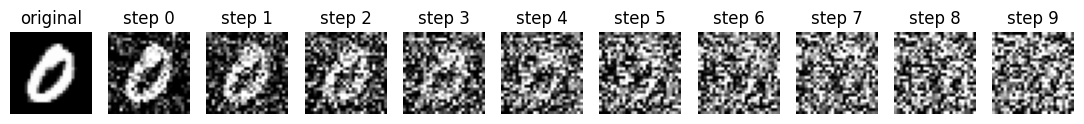

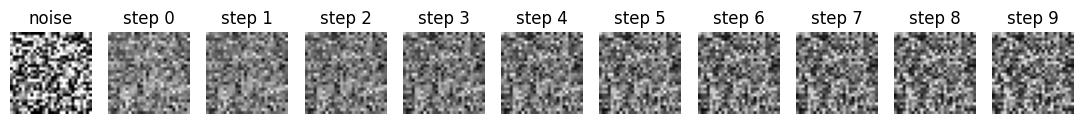

In [ ]:
from skimage.util import random_noise

def random_noise_fn(img_flat, var=0.1):
  return torch.Tensor(random_noise(img_flat, var=var))

model = Diffusion().to(device)
train(model, random_noise_fn, 20) #랜덤 노이즈로 학습
# model.eval()

# 잡음 추가 및 재구성
origin, _ = next(iter(val_loader))
restore_images(model, origin, random_noise_fn)

Epoch 0, Loss: 0.2791588008403778
Epoch 1, Loss: 0.26275596022605896
Epoch 2, Loss: 0.2626045048236847
Epoch 3, Loss: 0.2639053165912628
Epoch 4, Loss: 0.2577613592147827
Epoch 5, Loss: 0.25463956594467163
Epoch 6, Loss: 0.25012561678886414
Epoch 7, Loss: 0.25176024436950684
Epoch 8, Loss: 0.2543354332447052
Epoch 9, Loss: 0.2540917992591858
Epoch 10, Loss: 0.2540069818496704
Epoch 11, Loss: 0.2499815672636032
Epoch 12, Loss: 0.24646465480327606
Epoch 13, Loss: 0.2483098804950714
Epoch 14, Loss: 0.2502775192260742
Epoch 15, Loss: 0.2486332505941391
Epoch 16, Loss: 0.24544884264469147
Epoch 17, Loss: 0.2508818805217743
Epoch 18, Loss: 0.24853304028511047
Epoch 19, Loss: 0.25170662999153137


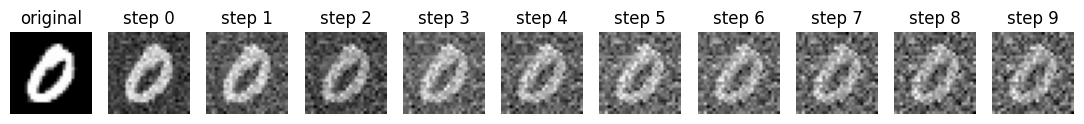

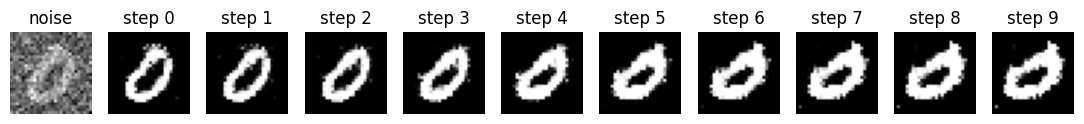

In [ ]:
import numpy as np

def langevin_dynamics(x_0, var=0.9, n_steps=10, step_size=0.05):

    # 스코어 함수
    def score_fn(x):
        noisy_data = x + np.random.normal(0, var, size=x.size())
        return x - noisy_data

    x = x_0
    for i in range(n_steps):
        grad = score_fn(x)
        noise = np.random.normal(0, step_size, size=x.shape)
        x = x + step_size*grad + noise
    return torch.Tensor(x).float()

model = Diffusion().to(device)
train(model, langevin_dynamics, 20) #langevin_dynamics 로 훈련
# model.eval()

# 잡음 추가 및 재구성
origin, _ = next(iter(val_loader))
restore_images(model, origin, langevin_dynamics)

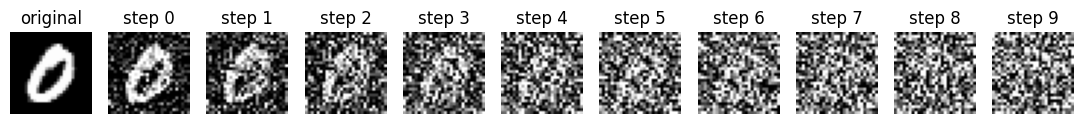

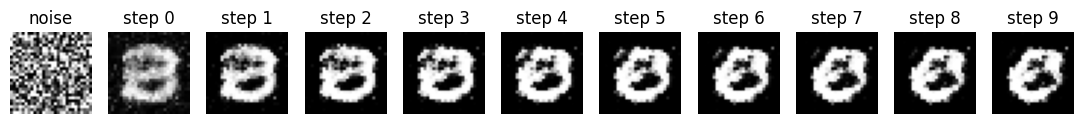

In [ ]:
restore_images(model, origin, random_noise_fn)

MLE 평균 추정값: -0.10384651739409384
ELBO 평균 추정값: -0.10384650528430939


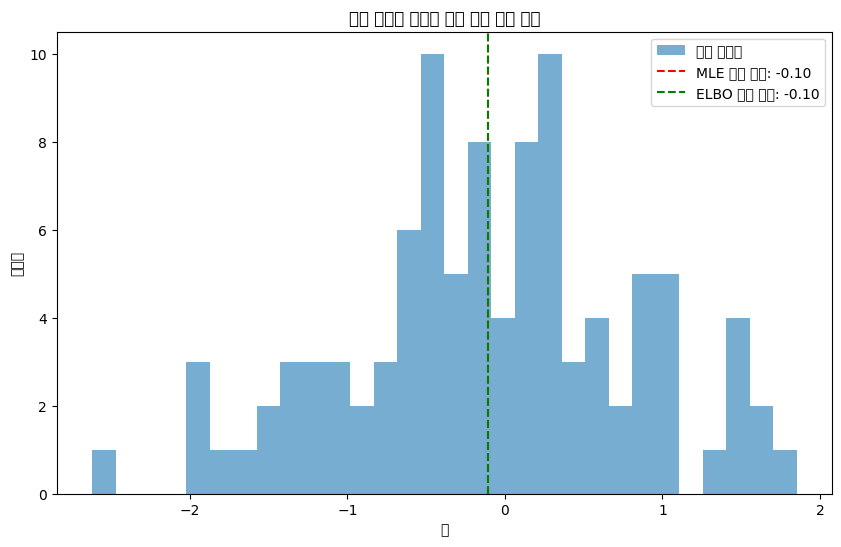

In [2]:
import numpy as np
import torch
from torch.distributions import Normal

# 데이터 생성
np.random.seed(42)
data = np.random.normal(0, 1, 100)  # 평균 0, 표준편차 1, 샘플 수 100

### 최대 우도 추정 (MLE)
mle_estimate = np.mean(data)
print(f"MLE 평균 추정값: {mle_estimate}")

### ELBO 추정
# 파라미터 초기화
mu = torch.tensor(1.0, requires_grad=True)  # 임의의 초기 평균 값
optimizer = torch.optim.Adam([mu], lr=0.1)  # 최적화 알고리즘 설정

# 데이터를 Tensor로 변환
data_tensor = torch.tensor(data, dtype=torch.float32)

# ELBO 최적화
for _ in range(1000):
    optimizer.zero_grad()
    # q(z) = N(mu, 1)로 가정
    q = Normal(mu, 1)
    # 로그 우도 계산
    log_likelihood = q.log_prob(data_tensor).sum()
    # ELBO는 여기서 로그 우도와 동일 (KL 항이 없음을 가정)
    # 실제 상황에서는 KL 발산 항을 추가해야 함
    loss = -log_likelihood
    loss.backward()
    optimizer.step()

print(f"ELBO 평균 추정값: {mu.item()}")

import matplotlib.pyplot as plt
# 실제 데이터 분포와 추정 결과를 시각화
plt.figure(figsize=(10, 6))
plt.hist(data, bins=30, alpha=0.6, label='실제 데이터')
plt.axvline(x=mle_estimate, color='red', linestyle='--', label=f'MLE 추정 평균: {mle_estimate:.2f}')
plt.axvline(x=mu.item(), color='green', linestyle='--', label=f'ELBO 추정 평균: {mu.item():.2f}')
plt.title('실제 데이터 분포와 평균 추정 결과 비교')
plt.xlabel('값')
plt.ylabel('빈도수')
plt.legend()
plt.show()
